<a href="https://colab.research.google.com/github/samarth2812/Creating-MNIST-Dataset-using-GAN/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

minst = MNIST(root ='data',
              train = True,
              download = True,
              transform= Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
img , label = minst[0]
print(' Label',label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

 Label 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [4]:
def denom(x):
  out = (x+1)/2
  return out.clamp(0,1)

Label 5


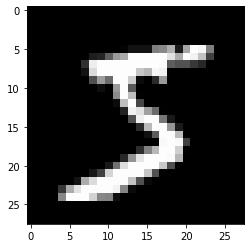

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

img_nom = denom(img)
plt.imshow(img_nom[0], cmap='gray')
print('Label',label)

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(minst, batch_size, shuffle = True)


In [7]:
for img_batch,label_batch in data_loader:
  print('first Batch')
  print(img_batch.shape)
  print(label_batch)
  break

first Batch
torch.Size([100, 1, 28, 28])
tensor([1, 9, 3, 6, 6, 8, 9, 1, 1, 5, 3, 8, 4, 3, 8, 9, 7, 2, 5, 1, 6, 0, 7, 0,
        1, 2, 2, 1, 7, 1, 5, 3, 2, 7, 6, 0, 0, 8, 5, 6, 5, 3, 6, 7, 7, 7, 0, 0,
        9, 1, 0, 2, 1, 7, 3, 9, 6, 0, 3, 3, 6, 6, 3, 1, 6, 4, 1, 4, 6, 0, 2, 4,
        9, 2, 7, 0, 6, 8, 2, 6, 0, 8, 7, 8, 9, 2, 7, 5, 3, 6, 3, 2, 6, 2, 6, 5,
        0, 0, 4, 9])


In [8]:
#Device Configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

In [10]:
image_size=784
hidden_size = 256

In [11]:
from torch.nn.modules.activation import LeakyReLU
import torch.nn as nn
D= nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size,1),
    nn.Sigmoid()

)

In [12]:
D.to(device);

In [13]:
latent_size = 64

In [14]:
G = nn.Sequential(
    nn.Linear(latent_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size , image_size),
    nn.Tanh()


)

In [15]:
y= G(torch.randn(2, latent_size))
gen_imgs = denom(y.reshape((-1,28,28)).detach())

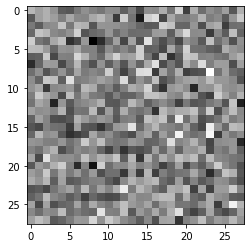

In [16]:
plt.imshow(gen_imgs[0], cmap='gray')

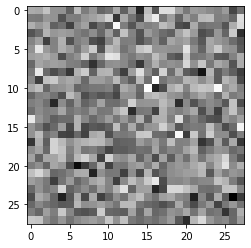

In [17]:
plt.imshow(gen_imgs[1], cmap='gray')

In [18]:
G.to(device);

In [ ]:
criterion= nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr =0.0002)
